# Detecting Synthetic Images


## Load Libraries

Ensure you have installed the following necessary packages

In [ ]:
%%capture

!pip3 install skorch torchview torchinfo hiddenlayer portalocker
!pip install datasets
!git lfs install
!git clone https://huggingface.co/HPAI-BSC/SuSy

Load libraries

In [ ]:
import torch
from torch import nn
import torchvision
from torch.nn import Conv2d, MaxPool2d, Linear
import torch.nn.functional as F
from torchvision.datasets import SVHN
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
import numpy as np
from torchview import draw_graph
from torchinfo import summary
import pandas as pd
import matplotlib.pyplot as plt
import hiddenlayer as hl
from timeit import default_timer as timer
import warnings
import torch.optim as optim
warnings.filterwarnings("ignore") #Conflict of nn.functional.act_f and torch.act_f
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import random
import time
import cv2
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import requests
from google.colab import files
from io import BytesIO
from tqdm import tqdm

print("You are using:")
!python --version
print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")


You are using:
Python 3.11.11
torch.__version__='2.5.1+cu124'
device=device(type='cpu')


Also load scripts with personalized functions

In [ ]:
from Manipulation_Funct import set_seed, stratified_sample, plot_exemples, resize_images, MinMaxScaler, check_class_distribution
from Smash_and_Reconstruction import smash_n_reconstruct, apply_all_filters

from OurModel_Funct import count_parameters, model_training, plot_results, model_testing, print_report
from OurModel_with_SR_Funct import model_training_SR, model_testing_SR, print_report_SR

from ResNet_Funct import resnet_training, plot_resnet_results, plot_resnet_confusion_matrix, resnet_train_sr, plot_resnet_confusion_matrix_sr

from SuSy_Funct import print_report_SuSy, ext_SuSy_pred


Set seed for reproducibility

In [ ]:
SEED = 42

USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())
    random.seed(SEED)


## Load Data

In [ ]:
!curl -X GET \
     "https://datasets-server.huggingface.co/splits?dataset=HPAI-BSC%2FSuSy-Dataset"

{"splits":[{"dataset":"HPAI-BSC/SuSy-Dataset","config":"susy_dataset","split":"train"},{"dataset":"HPAI-BSC/SuSy-Dataset","config":"susy_dataset","split":"val"},{"dataset":"HPAI-BSC/SuSy-Dataset","config":"susy_dataset","split":"test"}],"pending":[],"failed":[]}

In [ ]:
dataset = load_dataset("HPAI-BSC/SuSy-Dataset")

README.md:   0%|          | 0.00/9.71k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/15.2G [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/4.73G [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/6.02G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 14451
    })
    val: Dataset({
        features: ['image', 'label'],
        num_rows: 5555
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 5555
    })
})


The dataset is already splitted in train, validation and test sets.

The number of classes is 6, where 0 corresponds to authentic images, while classes from 1 to 5 corresponds to fake images.

Our aim is to distinguish between real and fake images, then, we sample from each of them, trying to keep some exemples for each class of the original data and balance the porportion for the binary classification task: fake VS real.

In [ ]:
prop = 1

train_data = stratified_sample(dataset["train"], percentage=prop)
val_data = stratified_sample(dataset["val"], percentage=prop)
test_data = stratified_sample(dataset["test"], percentage=prop)

print(f"Proportion used: {prop*100}%")
print(f"Train subset size: {len(train_data)}")
print(f"Validation subset size: {len(val_data)}")
print(f"Test subset size: {len(test_data)}\n")

# also check the number of exemples selected for each class in the training set
print("Label: Number of Occurrences")
lbl_occ = []
for lbl in np.unique(train_data['label']):

  lbl_occ.append(train_data['label'].count(lbl))
  print(f"{lbl}: {train_data['label'].count(lbl)}")

lbl_occ_cumsum = np.cumsum(lbl_occ)
lbl_occ_cumsum = [l-1 for l in lbl_occ_cumsum]

Proportion used: 100%
Train subset size: 5262
Validation subset size: 2096
Test subset size: 2096

Label: Number of Occurrences
0: 2967
1: 197
2: 593
3: 369
4: 543
5: 593


Plot some exemples, one for each class, to see how they figure

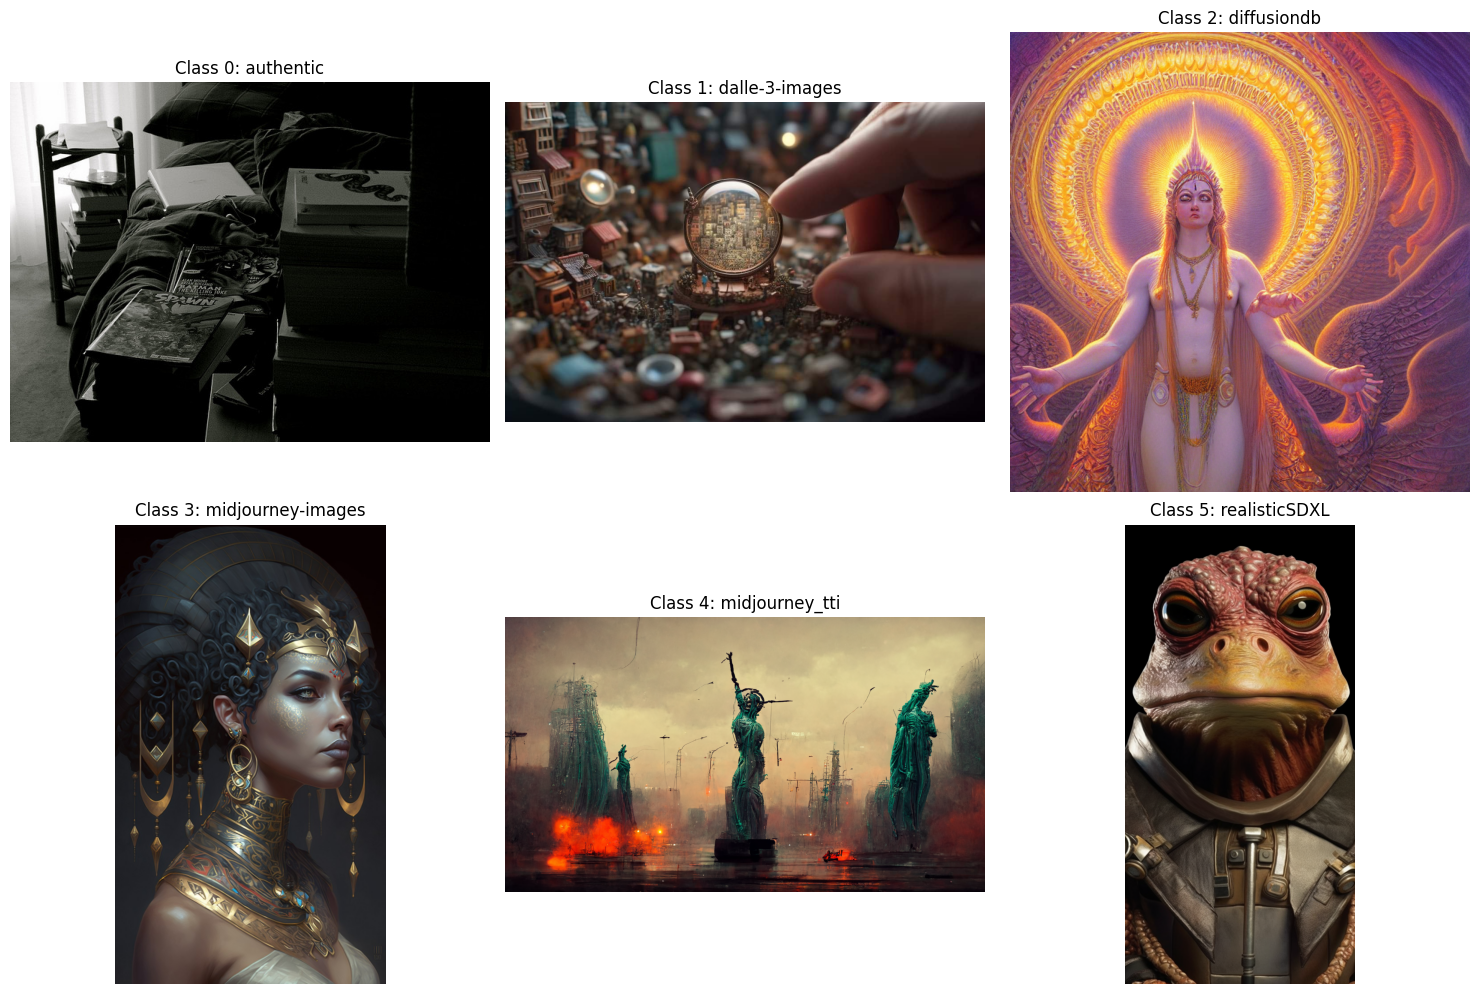

In [ ]:
plot_exemples(data = train_data, lbl_occ = lbl_occ)


## Data Preprocessing

### Resize Images

The images in the dataset have different shapes, as shown in the plot above. On the other hand, our CNN architecture needs input of the same size.

We decide to resize all images to 256x256 through bcubic interpolation.

In [ ]:
target_size =  (256, 256)

# Resizing train, validation, and test datasets
resized_train_data = resize_images(dataset = train_data, target_size = target_size, name="Train")
resized_val_data = resize_images(dataset = val_data, target_size = target_size, name = "Valid")
resized_test_data = resize_images(dataset = test_data, target_size = target_size, name = "Test")


Resizing Test Images: 100%|██████████| 2096/2096 [04:20<00:00,  8.03it/s]


Also we check if the resizing works as expected

In [ ]:
assert len(resized_train_data) == len(train_data), "The resized train set dimension is different from the original one"
assert len(resized_val_data) == len(val_data), "The resized val set dimension is different from the original one"
assert len(resized_test_data) == len(test_data), "The resized test set dimension is different from the original one"

print("Expected Image Shape:", target_size)

for idx, (img, _) in enumerate(resized_train_data):
    assert img.shape[:2]  ==  target_size, f"Error in training set at index {idx}"
for idx, (img, _) in enumerate(resized_val_data):
    assert img.shape[:2]  ==  target_size, f"Error in validation set at index {idx}"
for idx, (img, _) in enumerate(resized_test_data):
    assert img.shape[:2]  ==  target_size, f"Error in test set at index {idx}"

print("All images have the same shape")


Expected Image Shape: (256, 256)
All images have the same shape


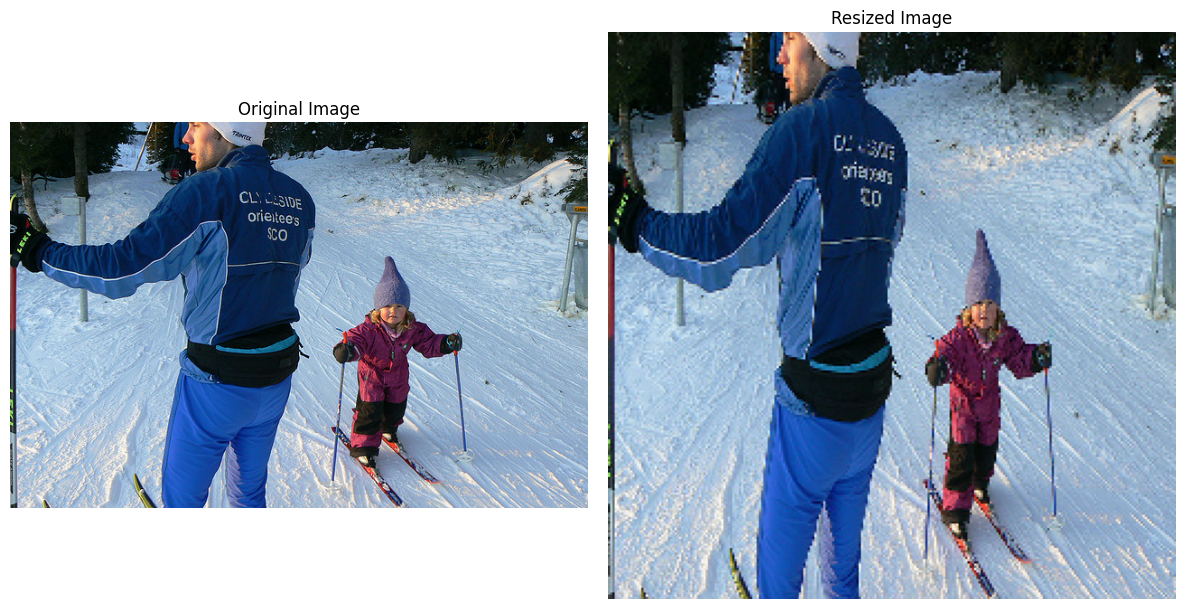

In [ ]:
# plot an exemple
idx = 2
image = train_data.take(3)['image'][idx]
resized_image = resized_train_data[idx]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
axes[0].imshow(image)
axes[0].axis('off')
axes[0].set_title("Original Image")

# Resized image
axes[1].imshow(resized_image[0])
axes[1].axis('off')
axes[1].set_title("Resized Image")

plt.tight_layout()
plt.show()


We can save and eventually save and load the resized images, this help us avoid to compute the previous operations every time

In [ ]:
def save_data(data, filename):
  torch.save(data, filename)
  print(f"Data saved to {filename}")

# save_data(resized_train_data, 'resized_train_data.pth')
# save_data(resized_val_data, 'resized_val_data.pth')
# save_data(resized_test_data, 'resized_test_data.pth')


In [ ]:
def load_data(filename):
  return torch.load(filename)

# resized_train_data = load_data('resized_train_data.pth')
# resized_val_data = load_data('resized_val_data.pth')
# resized_test_data = load_data('resized_test_data.pth')

# print(f"Loaded Train Data: {len(resized_train_data)} samples")
# print(f"Loaded Validation Data: {len(resized_val_data)} samples")
# print(f"Loaded Test Data: {len(resized_test_data)} samples")


### Smash&Reconstruction

The idea described in the report is implemented below. Basically, we first divide the image into patches of a predetermined size (32x32). Then we find the pixel gradient of these patches of the image (i.e. finding the difference between pixel values in horizontal, diagonal and counter diagonal directions and adding them all together) and separate them them into rich texture patches and poor texture patches.

Let's check ouw it works for one exemple

In [ ]:
rt1,pt1,lbl1 = smash_n_reconstruct(resized_image) # apply S&R


In [ ]:
# Apply filters
rt1f = apply_all_filters(rt1)
pt1f = apply_all_filters(pt1)


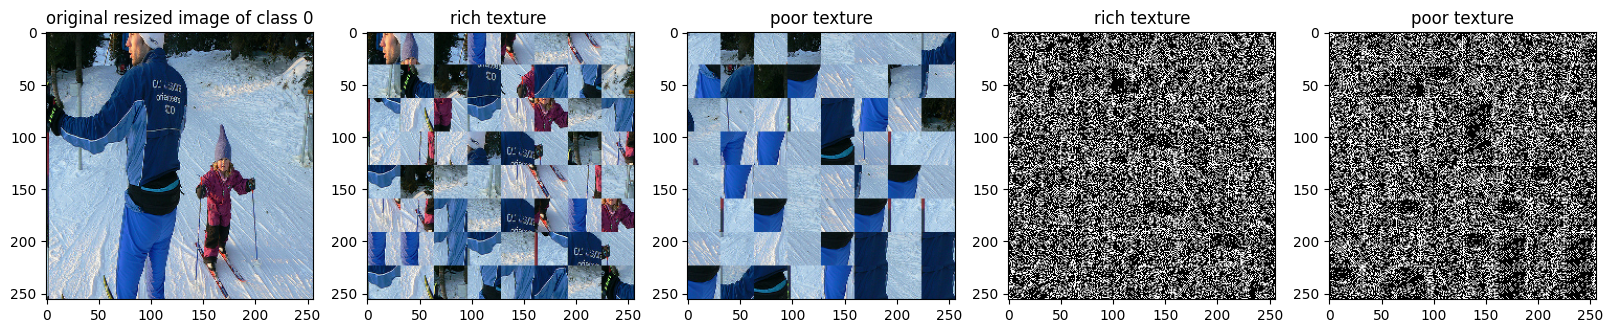

In [ ]:
plt.figure(figsize=(20, 15))

plt.subplot(1, 5, 1)
plt.imshow(resized_image[0])
plt.title(f'original resized image of class {resized_image[1]}')

plt.subplot(1, 5, 2)
plt.imshow(rt1)
plt.title('rich texture ')

plt.subplot(1, 5, 3)
plt.imshow(pt1)
plt.title('poor texture')

plt.subplot(1, 5, 4)
plt.imshow(rt1f, cmap='gray')
plt.title('rich texture')

plt.subplot(1, 5, 5)
plt.imshow(pt1f, cmap='gray')
plt.title('poor texture')

plt.show()


What happens for AI generated images?

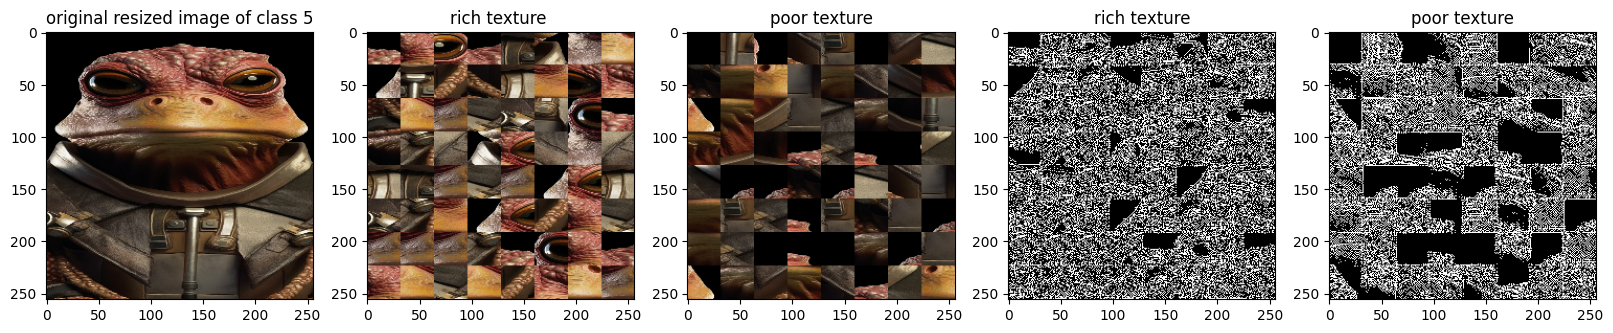

In [ ]:
idx_last = -1
resized_image_fake = resized_train_data[idx_last]

rt1,pt1,lbl1 = smash_n_reconstruct(resized_image_fake) # apply S&R

# Apply filters
rt1f = apply_all_filters(rt1)
pt1f = apply_all_filters(pt1)

plt.figure(figsize=(20, 15))

plt.subplot(1, 5, 1)
plt.imshow(resized_image_fake[0])
plt.title(f'original resized image of class {resized_image_fake[1]}')

plt.subplot(1, 5, 2)
plt.imshow(rt1)
plt.title('rich texture ')

plt.subplot(1, 5, 3)
plt.imshow(pt1)
plt.title('poor texture')

plt.subplot(1, 5, 4)
plt.imshow(rt1f, cmap='gray')
plt.title('rich texture')

plt.subplot(1, 5, 5)
plt.imshow(pt1f, cmap='gray')
plt.title('poor texture')

plt.show()

We can now apply this process to all images

In [ ]:
processed_train_images = [
  (apply_all_filters(rt), apply_all_filters(pt), lbl)
  for rt, pt, lbl in tqdm(
    map(smash_n_reconstruct, resized_train_data),
    total=len(resized_train_data),
    desc="Processing Training Images"
  )
]

processed_val_images = [
  (apply_all_filters(rt), apply_all_filters(pt), lbl)
  for rt, pt, lbl in tqdm(
    map(smash_n_reconstruct, resized_val_data),
    total=len(resized_val_data),
    desc="Processing Validation Images"
  )
]

processed_test_images = [
  (apply_all_filters(rt), apply_all_filters(pt), lbl)
  for rt, pt, lbl in tqdm(
    map(smash_n_reconstruct, resized_test_data),
    total=len(resized_test_data),
    desc="Processing Test Images"
  )
]


Processing Test Images: 100%|██████████| 2096/2096 [10:31<00:00,  3.32it/s]


In [ ]:
# save_data(processed_train_images, 'processed_train_images.pth')
# save_data(processed_val_images, 'processed_val_images.pth')
# save_data(processed_test_images, 'processed_test_images.pth')


In [ ]:
# processed_train_images = load_data('processed_train_images.pth')
# processed_val_images = load_data('processed_val_images.pth')
# processed_test_images = load_data('processed_test_images.pth')

# print(f"Loaded Train Data: {len(processed_train_images)} samples")
# print(f"Loaded Validation Data: {len(processed_val_images)} samples")
# print(f"Loaded Test Data: {len(processed_test_images)} samples")


### Prepare Data for Model Training


At this stage, we ensure that the data has an appropriate structure for training the models. Specifically, we assign a target label of 0 to real images and 1 to AI-generated images.

Additionally, we compare similar architectures when trained on data preprocessed with Smash & Reconstruction versus data that has not undergone any preprocessing. This comparison will help evaluate the impact of preprocessing on model performance.

In [ ]:
# dataset with S&R preprocessed images
class CustomDataset_SR(Dataset):

  def __init__(self, images, labels):
    self.images = images
    self.labels = labels

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    rt, pt, label = self.images[idx]

    rt1 = torch.from_numpy(rt).unsqueeze(0).float()
    pt1 = torch.from_numpy(pt).unsqueeze(0).float()

    if label != 0:
      label = 1 # --> Fake when label=1,2,3,4,5; Real when label=0

    return rt1, pt1, label


In [ ]:
train_data_SR = CustomDataset_SR(
  images = processed_train_images,
  labels = train_data["label"],
)

val_data_SR = CustomDataset_SR(
  images = processed_val_images,
  labels = val_data["label"],
)

test_data_SR = CustomDataset_SR(
  images = processed_test_images,
  labels = test_data["label"],
)

Then we prepare data without the S&R preporcess, in this case we also apply a scaling function. The main reason why having features with similar scales is a good idea is that different scales can lead to issues in optimizing the loss function.

Having different scales may result in a highly irregular loss function surface, causing problems for optimization methods like gradient descent as it struggles to find the optimal direction and faces challenges with gradient updates because step sizes may be too long or too short. This can lead to algorithm non-convergence or gradient saturation, beacuse gradients become too large for big scale features and too small for smaller scale features.

In addition to these optimization and numerical instability issues, having widely varying scales can cause overfitting because features with large scales would have more weight in the CNN than those with smaller scales, which would be ignored

In [ ]:
# dataset without S&R preprocessed images
class CustomDataset_NP(Dataset):

  def __init__(self, resized_data, transform=MinMaxScaler):
    self.images, original_labels  = zip(*resized_data)
    self.labels = [1 if x != 0 else 0 for x in original_labels] # divide images in real VS fake
    self.transform = transform


  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img = self.images[idx]
    label = self.labels[idx]

    if self.transform:
      img = self.transform(img)

    return img, torch.tensor(label, dtype=torch.long)



In [ ]:
train_data_NP = CustomDataset_NP(resized_train_data)
val_data_NP = CustomDataset_NP(resized_val_data)
test_data_NP = CustomDataset_NP(resized_test_data)


## Custom CNN Architecture

### Model Definition and Training for Original Data


In [ ]:
batch_size = 32

dataloader_training_NP = DataLoader(train_data_NP, batch_size=batch_size, shuffle=True)
dataloader_validation_NP = DataLoader(val_data_NP, batch_size=batch_size)
dataloader_test_NP = DataLoader(test_data_NP, batch_size=batch_size)


In [ ]:
print("Class distribution in training dataset:", check_class_distribution(dataloader_training_NP))
print("Class distribution in validation dataset:", check_class_distribution(dataloader_validation_NP))
print("Class distribution in test dataset:", check_class_distribution(dataloader_test_NP))


Class distribution in training dataset: {0: 2967, 1: 2295}
Class distribution in validation dataset: {0: 1234, 1: 862}
Class distribution in test dataset: {0: 1234, 1: 862}


We define the following architecture that takes in input RGB imgaes and pass it through 6 convolutional layers and lastly to 2 FC layers.

In [ ]:
class OurNet_NP(nn.Module):

  def __init__(self, output_dim):

    super().__init__()

    # Conv Layers
    self.features = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),

      nn.Conv2d(in_channels=6, out_channels=8, kernel_size=3),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.BatchNorm2d(8),
      nn.ReLU(),

      nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.ReLU(),

      nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
      nn.BatchNorm2d(16),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),

      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
      nn.MaxPool2d(kernel_size=2),
      nn.ReLU(),
    )

    # FC Layers
    self.fc = nn.Sequential(
      nn.Dropout(0.5),
      nn.Linear(1568, 512),
      nn.ReLU(),
      nn.Linear(512, output_dim)
    )

  def forward(self, x):

    x = self.features(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)

    return x

In [ ]:
OUTPUT_DIM = 2
model = OurNet_NP(OUTPUT_DIM)

print(f"The model has {count_parameters(model):,} trainable parameters.")


The model has 825,714 trainable parameters.


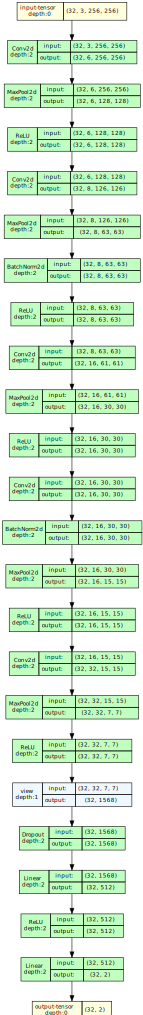

In [ ]:
model_graph = draw_graph(model,
                         input_size=(batch_size,
                                     3, #RGB
                                     256, 256),
                         device=device)

model_graph.visual_graph

In [ ]:
# Loss
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-5)

model = model.to(device)


We proceed by training the model for 15 epochs. The saved model will be the one with lowest validation loss.

In [ ]:
N_EPOCHS = 15
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS, model,
                                                                    dataloader_training_NP, dataloader_validation_NP,
                                                                    optimizer, criterion,
                                                                    device, 'ournet_np.pt')



Epoch: 1/15 -- Epoch Time: 187.10 s
---------------------------------
Train -- Loss: 0.632, Acc: 65.77%
Val -- Loss: 0.558, Acc: 73.86%

Epoch: 2/15 -- Epoch Time: 169.02 s
---------------------------------
Train -- Loss: 0.563, Acc: 71.67%
Val -- Loss: 0.518, Acc: 75.57%

Epoch: 3/15 -- Epoch Time: 160.89 s
---------------------------------
Train -- Loss: 0.525, Acc: 74.74%
Val -- Loss: 0.482, Acc: 77.84%

Epoch: 4/15 -- Epoch Time: 158.33 s
---------------------------------
Train -- Loss: 0.489, Acc: 76.96%
Val -- Loss: 0.476, Acc: 77.56%

Epoch: 5/15 -- Epoch Time: 158.39 s
---------------------------------
Train -- Loss: 0.474, Acc: 77.78%
Val -- Loss: 0.461, Acc: 79.17%

Epoch: 6/15 -- Epoch Time: 161.28 s
---------------------------------
Train -- Loss: 0.456, Acc: 79.19%
Val -- Loss: 0.456, Acc: 78.98%

Epoch: 7/15 -- Epoch Time: 180.84 s
---------------------------------
Train -- Loss: 0.446, Acc: 79.92%
Val -- Loss: 0.436, Acc: 80.11%

Epoch: 8/15 -- Epoch Time: 161.05 s
----

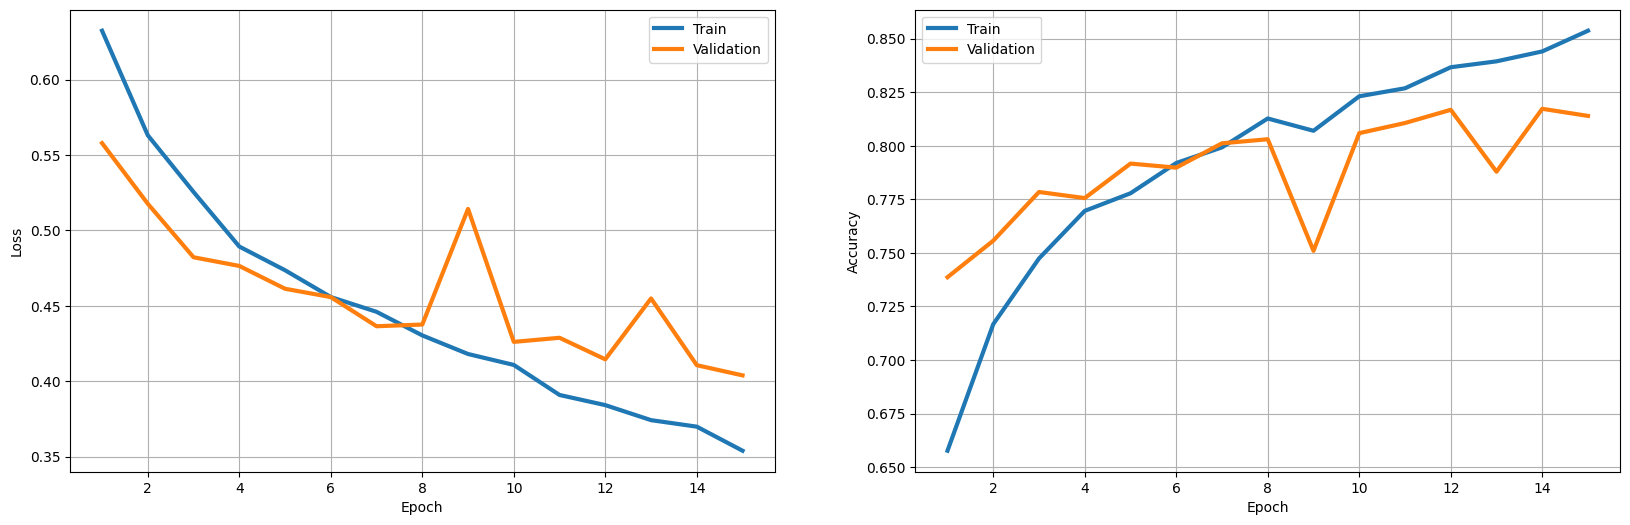

In [ ]:
plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)


The learning process is not stable and seems like the accuracy loss will not follow the same behaviour of the training one. It suggest the need of deeper architectures (next section).

The final selected model is the one at epoch 15, for which we have:

```
Epoch: 15/15 -- Epoch Time: 162.78 s
---------------------------------
Train -- Loss: 0.354, Acc: 85.37%
Val -- Loss: 0.404, Acc: 81.39%
```

These accuracy and loss values are similar for training and validation set, but also for the test set as shown below.


Test -- Loss: 0.424, Acc: 81.39 %
Confusion Matrix:
 [[1022  212]
 [ 177  685]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84      1234
           1       0.76      0.79      0.78       862

    accuracy                           0.81      2096
   macro avg       0.81      0.81      0.81      2096
weighted avg       0.82      0.81      0.81      2096



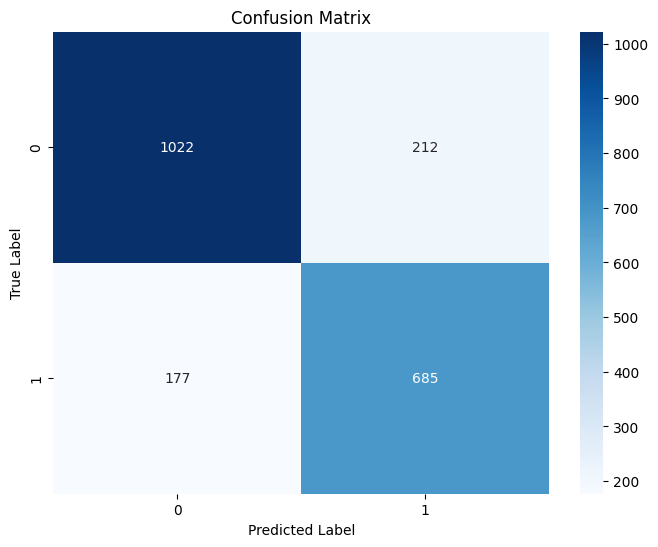

In [ ]:
model_testing(model, dataloader_test_NP, criterion, device, 'ournet_np.pt')
print_report(model, dataloader_test_NP, device)


### Model Definition and Training for S&R Data


In [ ]:
batch_size = 32

dataloader_training_SR = DataLoader(train_data_SR, batch_size=batch_size, shuffle=True)
dataloader_validation_SR = DataLoader(val_data_SR, batch_size=batch_size)
dataloader_test_SR = DataLoader(test_data_SR, batch_size=batch_size)


In [ ]:
class featureExtractionLayer(nn.Module):

  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1),
    nn.BatchNorm2d(3),
    nn.Hardtanh(),
  )

  def forward(self, x):
    return self.features(x)

class OurNet_SR(nn.Module):

 def __init__(self, output_dim):
  super().__init__()
  self.features = nn.Sequential(

    nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(),

    nn.Conv2d(in_channels=6, out_channels=8, kernel_size=3),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.BatchNorm2d(8),
    nn.ReLU(),

    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.ReLU(),

    nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, padding=2),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(),

    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
    nn.MaxPool2d(kernel_size=2),
    nn.ReLU(),

  )

  # Fully Connected Layers
  self.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(1568, 512),
    nn.ReLU(),
    nn.Linear(512, output_dim)
  )

 def forward(self, x):
  x = self.features(x)
  x = x.view(x.shape[0], -1)
  x = self.fc(x)
  return x

class FullModel(nn.Module):
  def __init__(self, output_dim):
    super().__init__()

    self.feature_extractor1 = featureExtractionLayer()
    self.feature_extractor2 = featureExtractionLayer()

    self.our_net = OurNet_SR(output_dim)

  def forward(self, rt1, pt1):

    rt_features = self.feature_extractor1(rt1)
    pt_features = self.feature_extractor2(pt1)
    diff = torch.sub(rt_features, pt_features)

    output = self.our_net(diff)

    return output


In [ ]:
output_dim = 2
model1 = FullModel(output_dim)

print(f"The model has {count_parameters(model1):,} trainable parameters.")


The model has 825,786 trainable parameters.


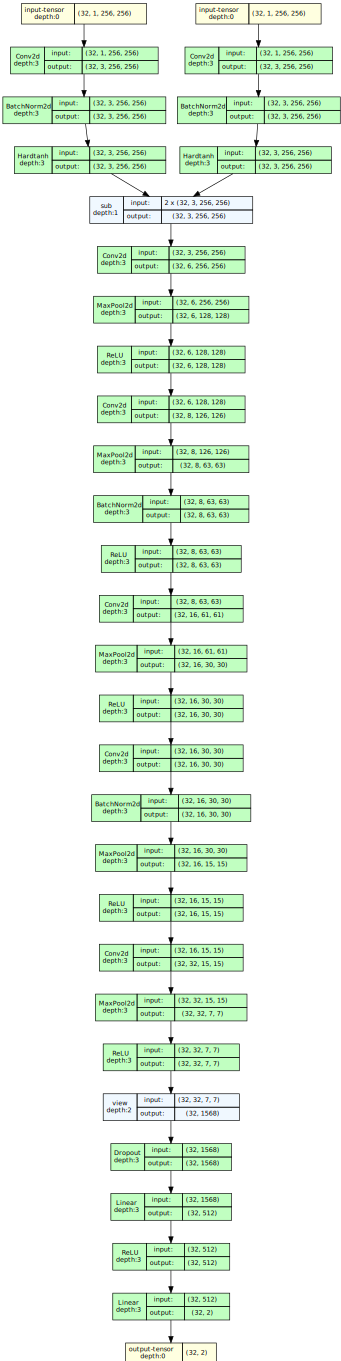

In [ ]:
input_size = (32, 1, 256, 256)
model_graph = draw_graph(model1,
                         input_data=(torch.randn(*input_size), torch.randn(*input_size)),
                         device=device)

model_graph.visual_graph

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

N_EPOCHS = 15
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
train_losses1, train_accuracies1, valid_losses1, valid_accuracies1 = model_training_SR(
    model = model1,
    dataloader_training = dataloader_training_SR,
    dataloader_validation = dataloader_validation_SR,
    optimizer = optimizer,
    criterion = criterion,
    num_epochs = N_EPOCHS,
    step_size = 5,
    gamma = 0.5,
    model_name = 'ournet_sr.pt'
    )



Epoch: 1/15 -- Epoch Time: 296.22 s
---------------------------------
Train -- Loss: 0.694, Acc: 51.75%
Val -- Loss: 0.697, Acc: 50.05%

Epoch: 2/15 -- Epoch Time: 281.65 s
---------------------------------
Train -- Loss: 0.691, Acc: 51.88%
Val -- Loss: 0.701, Acc: 47.42%

Epoch: 3/15 -- Epoch Time: 303.10 s
---------------------------------
Train -- Loss: 0.692, Acc: 52.19%
Val -- Loss: 0.695, Acc: 50.91%

Epoch: 4/15 -- Epoch Time: 286.32 s
---------------------------------
Train -- Loss: 0.692, Acc: 51.41%
Val -- Loss: 0.698, Acc: 49.67%

Epoch: 5/15 -- Epoch Time: 296.56 s
---------------------------------
Train -- Loss: 0.696, Acc: 50.06%
Val -- Loss: 0.698, Acc: 49.57%

Epoch: 6/15 -- Epoch Time: 320.88 s
---------------------------------
Train -- Loss: 0.692, Acc: 51.92%
Val -- Loss: 0.697, Acc: 50.05%

Epoch: 7/15 -- Epoch Time: 308.87 s
---------------------------------
Train -- Loss: 0.694, Acc: 51.79%
Val -- Loss: 0.697, Acc: 50.19%

Epoch: 8/15 -- Epoch Time: 314.53 s
----

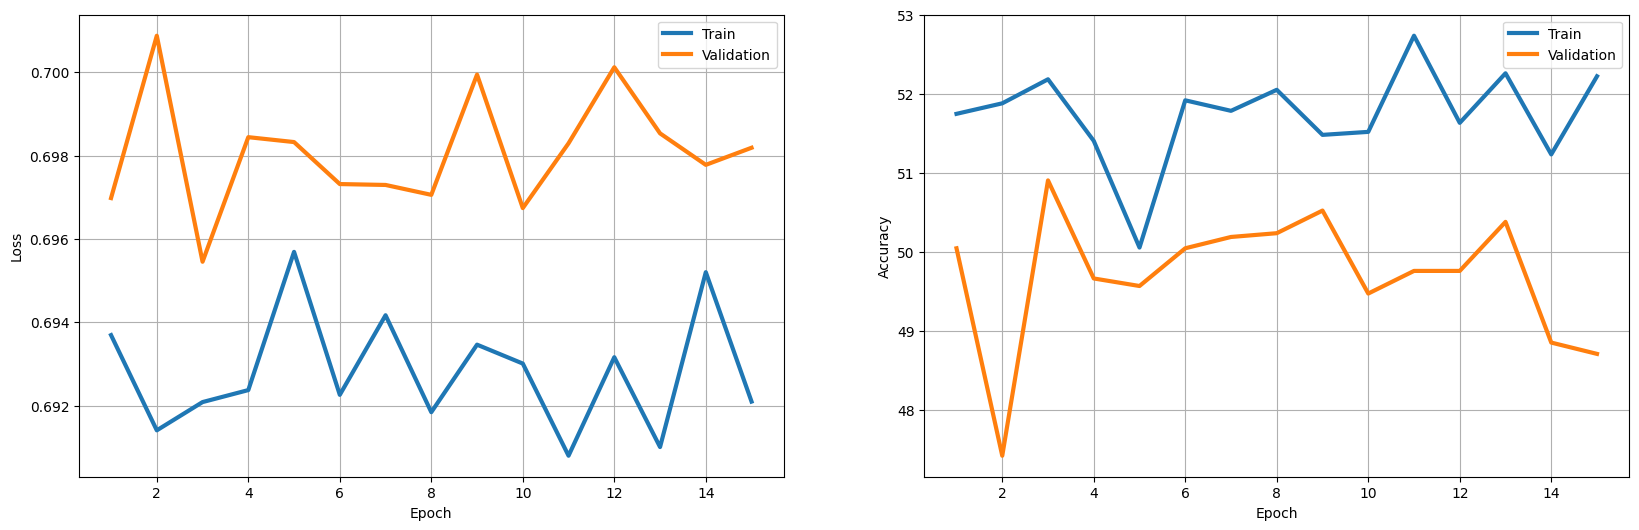

In [ ]:
plot_results(N_EPOCHS, train_losses1, train_accuracies1, valid_losses1, valid_accuracies1)


Test -- Loss: 0.689, Acc: 57.39 %
Confusion Matrix:
 [[833 401]
 [490 372]]

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.68      0.65      1234
           1       0.48      0.43      0.46       862

    accuracy                           0.57      2096
   macro avg       0.56      0.55      0.55      2096
weighted avg       0.57      0.57      0.57      2096



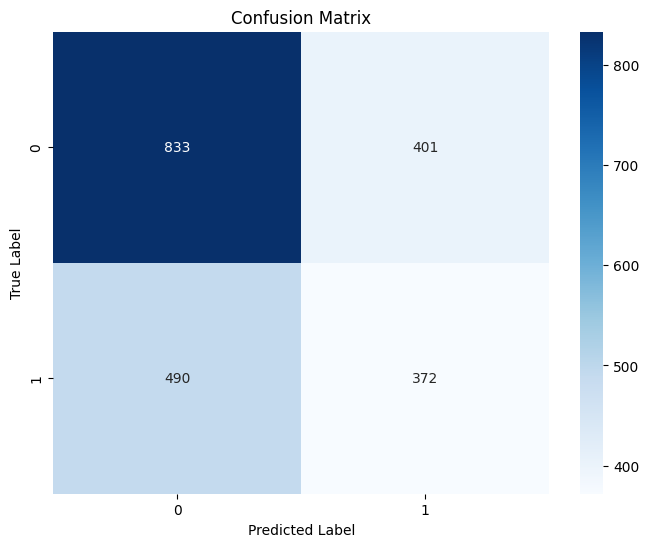

In [ ]:
model_testing_SR(model1, dataloader_test_SR, criterion, device, 'ournet_sr.pt')
print_report_SR(model1, dataloader_test_SR, device)


## ResNet18 Model

### ResNet18 Architecture and Training for Original Data

The model originally has a 2048-dimensional output layer, but our dataset has only 2 classes (real and fake), so we add a new layer with just 2 neurons. The parameters of these new neurons are initialized with Xavier initialization.

In [ ]:
batch_size = 4 # we reduce batch size wrt to previous models

dataloader_training_NP = DataLoader(train_data_NP, batch_size=batch_size, shuffle=True)
dataloader_validation_NP = DataLoader(val_data_NP, batch_size=batch_size)
dataloader_test_NP = DataLoader(test_data_NP, batch_size=batch_size)


In [ ]:
def get_net1(train_all_layers:bool=False):

  resnet = torchvision.models.resnet50(pretrained=True)

  if train_all_layers:
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 2) # add just the output layer
    torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

  in_features = resnet.fc.in_features
  resnet.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features, 2)
    )

  torch.nn.init.xavier_uniform_(resnet.fc[0].weight)

  # freez all the params (except the last layers)
  for param in resnet.parameters():
      param.requires_grad = False
  for param in resnet.fc.parameters():
      param.requires_grad = True

  return resnet

device = 'cuda' if torch.cuda.is_available() else 'cpu'
our_resnet_np = get_net1().to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 91.0MB/s]


In [ ]:
# Check which layers we are going to train
for name, param in our_resnet_np.named_parameters():
  if param.requires_grad == True:
    print(f"{name}: requires_grad={param.requires_grad}")


fc.0.weight: requires_grad=True
fc.0.bias: requires_grad=True


In [ ]:
lr, weight_decay, N_EPOCH = 1e-5, 5e-4, 10

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(our_resnet_np.fc.parameters(), lr=lr, weight_decay=weight_decay)


In [ ]:
resnet_np, train_losses3, train_accs3, valid_losses3, valid_accs3 = resnet_training(
    net = our_resnet_np,
    train_dataloader = dataloader_training_NP,
    valid_dataloader = dataloader_validation_NP,
    criterion = criterion, optimizer = optimizer,
    epochs=N_EPOCH, device=device, model_name='resnet_np.pt'
    )


Epoch: 1/10 -- Epoch Time: 2314.80 s
---------------------------------
Train -- Loss: 3521.018, Acc: 59.96%
Val -- Loss: 1222.660, Acc: 68.65%

Epoch: 2/10 -- Epoch Time: 2267.66 s
---------------------------------
Train -- Loss: 3019.654, Acc: 70.90%
Val -- Loss: 1001.622, Acc: 79.44%

Epoch: 3/10 -- Epoch Time: 2313.82 s
---------------------------------
Train -- Loss: 2712.127, Acc: 76.99%
Val -- Loss: 875.225, Acc: 83.35%

Epoch: 4/10 -- Epoch Time: 2301.91 s
---------------------------------
Train -- Loss: 2513.445, Acc: 79.78%
Val -- Loss: 797.578, Acc: 85.45%

Epoch: 5/10 -- Epoch Time: 2313.97 s
---------------------------------
Train -- Loss: 2402.969, Acc: 81.05%
Val -- Loss: 729.664, Acc: 87.45%

Epoch: 6/10 -- Epoch Time: 2345.20 s
---------------------------------
Train -- Loss: 2309.771, Acc: 81.45%
Val -- Loss: 680.897, Acc: 88.17%

Epoch: 7/10 -- Epoch Time: 2316.33 s
---------------------------------
Train -- Loss: 2256.346, Acc: 81.51%
Val -- Loss: 666.268, Acc: 88.2

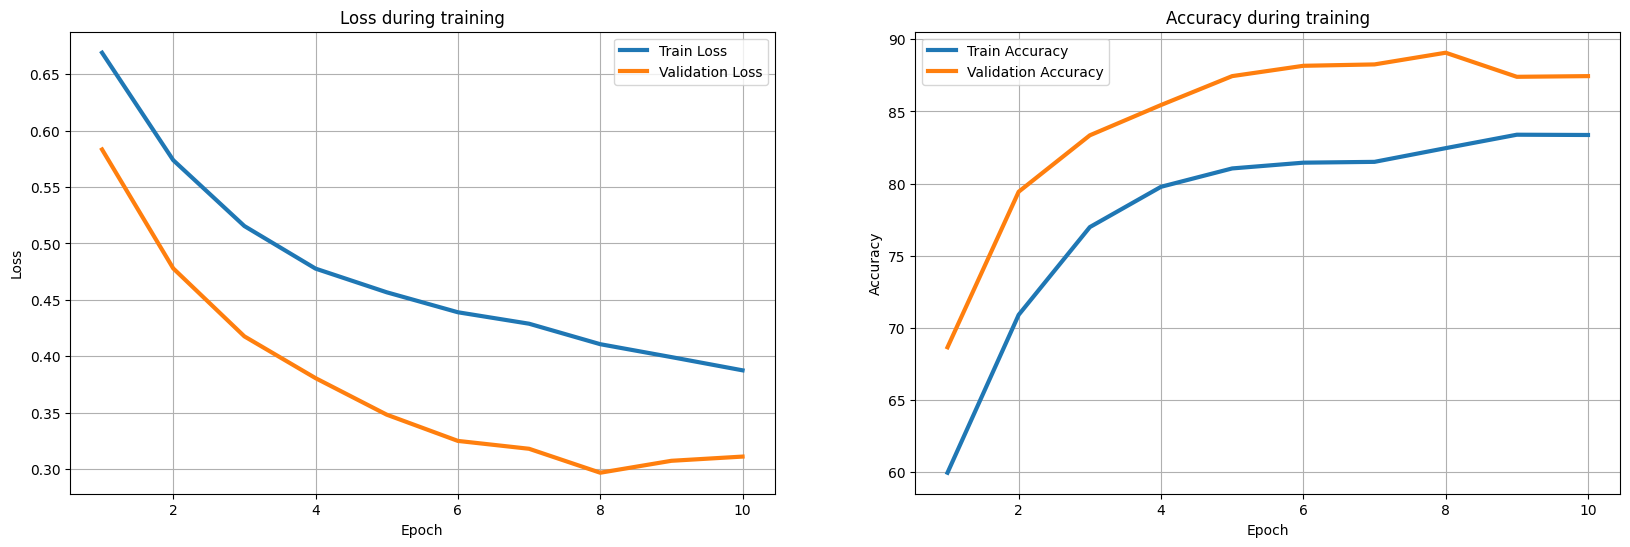

In [ ]:
plot_resnet_results(N_EPOCH, train_losses3, train_accs3, valid_losses3, valid_accs3)



Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.97      0.89      1234
           1       0.95      0.71      0.81       862

    accuracy                           0.86      2096
   macro avg       0.89      0.84      0.85      2096
weighted avg       0.88      0.86      0.86      2096



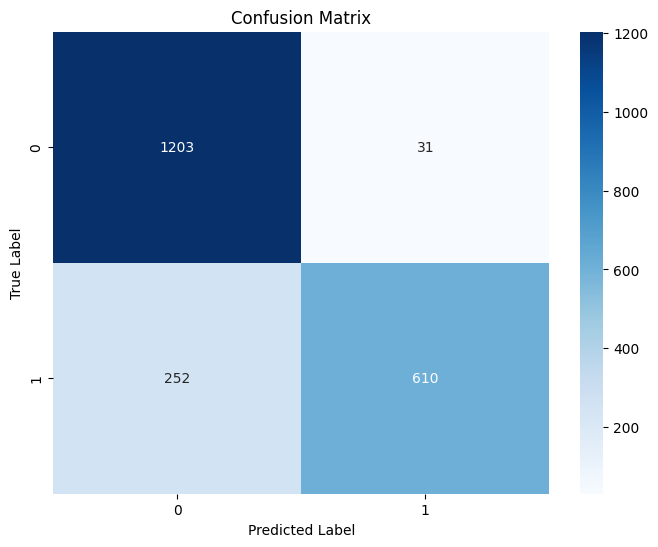

In [ ]:
plot_resnet_confusion_matrix(model = our_resnet_np, dataloader = dataloader_test_NP,
                             true_labels = test_data_NP.labels, device=device)
# note: we use test_data_NP.labels bc we didn't shuffle in Dataloader


### ResNet18 Architecture and Training for S&R Data

In [ ]:
batch_size = 4

dataloader_training_SR = DataLoader(train_data_SR, batch_size=batch_size, shuffle=True)
dataloader_validation_SR = DataLoader(val_data_SR, batch_size=batch_size)
dataloader_test_SR = DataLoader(test_data_SR, batch_size=batch_size)

In [ ]:
class featureExtractionLayer(nn.Module):

  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=2),
    nn.BatchNorm2d(3),
    nn.Hardtanh(),
  )

  def forward(self, x):
    return self.features(x)

def get_net():

  resnet = torchvision.models.resnet18(pretrained=True)

  in_features = resnet.fc.in_features
  resnet.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features, 2)
    )

  torch.nn.init.xavier_uniform_(resnet.fc[0].weight) # initialize w Xavier

  # freez all params of resnet
  for param in resnet.parameters():
    param.requires_grad = False
  # except ours
  for param in resnet.fc.parameters():
    param.requires_grad = True

  return resnet


In [ ]:
resnet_sr = get_net().to(device)

feature_extractor1 = featureExtractionLayer().to(device)
feature_extractor2 = featureExtractionLayer().to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


In [ ]:
lr, weight_decay, N_EPOCH = 1e-5, 5e-4, 10

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_sr.fc.parameters(), lr=lr, weight_decay=weight_decay)


In [ ]:
train_losses4, train_accs4, valid_losses4, valid_accs4 = resnet_train_sr(
  net = resnet_sr,
  feature_extractor1 = feature_extractor1,
  feature_extractor2 = feature_extractor2,
  train_dataloader = dataloader_training_SR,
  valid_dataloader = dataloader_test_SR,
  criterion = criterion,
  optimizer = optimizer,
  epochs=N_EPOCH,
  device=device,
  model_name="resnet_sr.pt"
  )



Epoch: 1/10 -- Epoch Time: 1789.14 s
---------------------------------
Train -- Loss: 0.908, Acc: 43.75%
Val -- Loss: 0.849, Acc: 48.19%

Epoch: 2/10 -- Epoch Time: 1805.34 s
---------------------------------
Train -- Loss: 0.779, Acc: 50.06%
Val -- Loss: 0.806, Acc: 50.57%

Epoch: 3/10 -- Epoch Time: 1810.22 s
---------------------------------
Train -- Loss: 0.733, Acc: 53.33%
Val -- Loss: 0.741, Acc: 57.49%

Epoch: 4/10 -- Epoch Time: 1803.25 s
---------------------------------
Train -- Loss: 0.701, Acc: 58.19%
Val -- Loss: 0.734, Acc: 59.64%

Epoch: 5/10 -- Epoch Time: 1807.05 s
---------------------------------
Train -- Loss: 0.678, Acc: 60.72%
Val -- Loss: 0.700, Acc: 60.97%

Epoch: 6/10 -- Epoch Time: 1797.90 s
---------------------------------
Train -- Loss: 0.662, Acc: 63.04%
Val -- Loss: 0.685, Acc: 62.83%

Epoch: 7/10 -- Epoch Time: 1804.51 s
---------------------------------
Train -- Loss: 0.660, Acc: 62.33%
Val -- Loss: 0.690, Acc: 62.50%

Epoch: 8/10 -- Epoch Time: 1795.0

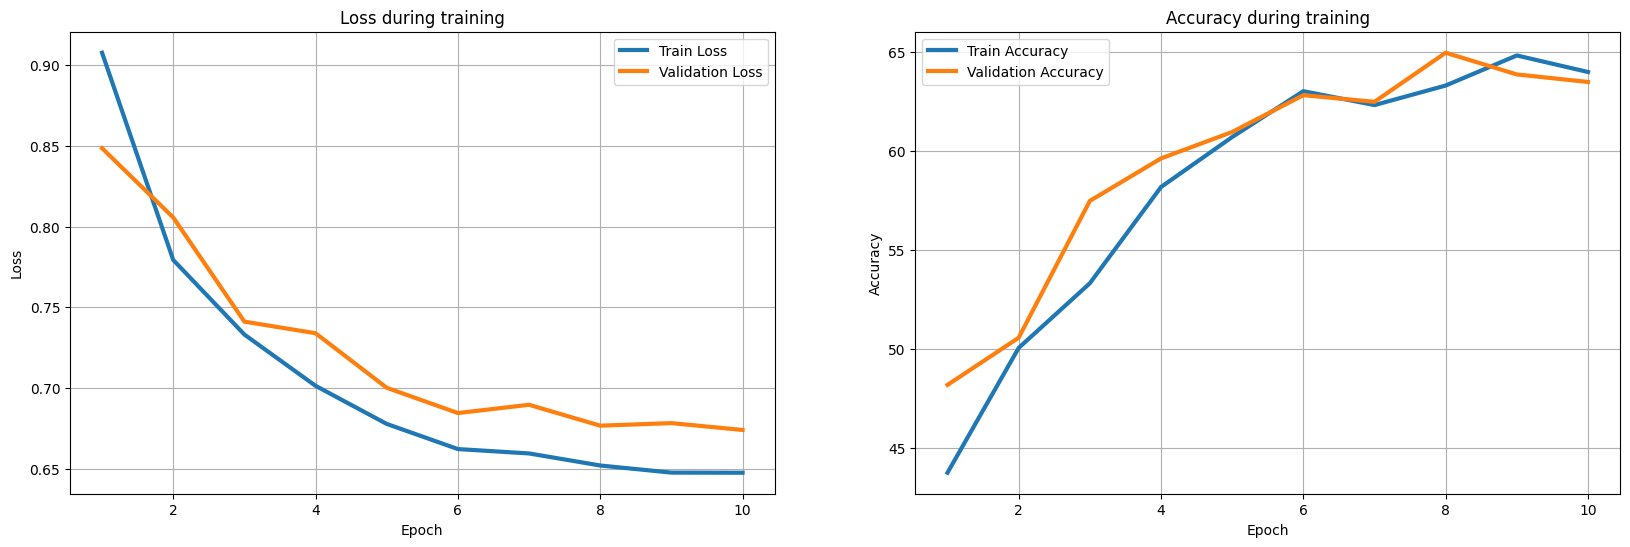

In [ ]:
plot_resnet_results(N_EPOCH, train_losses4, train_accs4, valid_losses4, valid_accs4)


Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.72      0.70      1234
           1       0.56      0.51      0.53       862

    accuracy                           0.64      2096
   macro avg       0.62      0.62      0.62      2096
weighted avg       0.63      0.64      0.63      2096



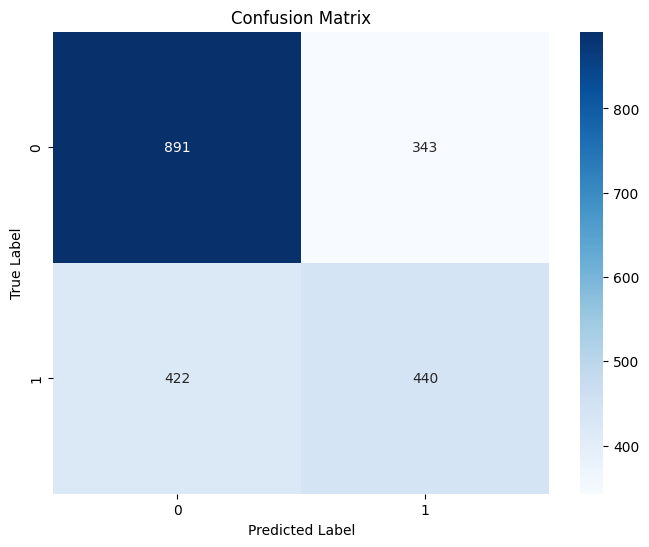

In [ ]:
plot_resnet_confusion_matrix_sr(model=resnet_sr, f_extr1=feature_extractor1, f_extr2=feature_extractor2,
                                dataloader=dataloader_test_SR, device=device)


## SuSy

In [ ]:
# Load the model
SuSy = torch.jit.load("SuSy/SuSy.pt")

[[1193   41]
 [   4  858]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1234
           1       0.95      1.00      0.97       862

    accuracy                           0.98      2096
   macro avg       0.98      0.98      0.98      2096
weighted avg       0.98      0.98      0.98      2096



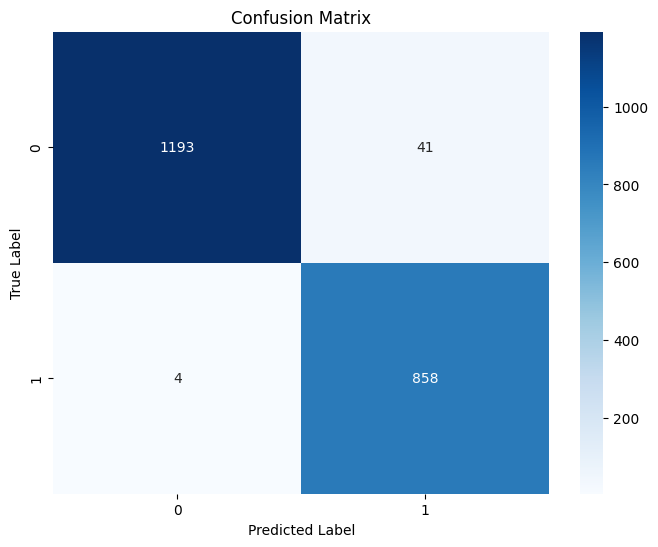

In [ ]:
# make the predictions
susy_preds = print_report_SuSy(test_data, SuSy)

## Test Images from Another Dataset

#### Load Data

Keep images from [external dataset](https://huggingface.co/datasets/InfImagine/FakeImageDataset).
The idea is to test the mdoels performance on different images.

Then we start by loading the data and sample some test exemples.

In [ ]:
!curl -X GET \
  "https://datasets-server.huggingface.co/first-rows?dataset=mncai%2FFake_or_Real_Competition_Dataset&config=default&split=train"
!curl -X GET \
  "https://datasets-server.huggingface.co/splits?dataset=mncai%2FFake_or_Real_Competition_Dataset"

{"dataset":"mncai/Fake_or_Real_Competition_Dataset","config":"default","split":"train","features":[{"feature_idx":0,"name":"image","type":{"_type":"Image"}},{"feature_idx":1,"name":"label","type":{"names":["fake_images","images","real_images"],"_type":"ClassLabel"}}],"rows":[{"row_idx":0,"row":{"image":{"src":"https://datasets-server.huggingface.co/assets/mncai/Fake_or_Real_Competition_Dataset/--/default/train/0/image/image.jpg?Expires=1739537261&Signature=HrNyMUKpmEx9bUp962mFw9Tnr~3ni5RQ~rqF0uHiIjLiwxj6rMJHLGGNvwVOaL6oBJTQwt0Zqcj0oY4CugQltko7CVeUj-NYJZ7dwPDEXeOZXOPwLuz9okfGwYQRVeoDKeAdyG5WSsxpSHtxBRuZcnKezxdfNwDX6-xyTLZRxt-GTYK9BrAD48ZiI52114j9YAeQTXZTINuaaMFv0Yq1dNUWlC1krOXxo1S3ZKqEHWqPFXTeXcwiBC6dAz-xoZGXIS9nmqLcQqlOvc8IKaGVNFhrWcTCzLqfm3YsSDwKIVIqTFAzeZtD1Nntz9pOn27LNRkI~MnmTL-~TaTpB-akyQ__&Key-Pair-Id=K3EI6M078Z3AC3","height":512,"width":512},"label":0},"truncated_cells":[]},{"row_idx":1,"row":{"image":{"src":"https://datasets-server.huggingface.co/assets/mncai/Fake_or_Real_Compet

In [ ]:
data = load_dataset("mncai/Fake_or_Real_Competition_Dataset")

print(data)

README.md:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/9.00G [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/18.7G [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 58348
    })
})


#### Preprocess Data


As first step, we sample 2000 images from the dataset and we ensure all of them to be at least 224x224, since SuSy cannot deal with smaller images.

In [ ]:
all_lbls = pd.Series(data['train']['label'])
num_samples_per_class = 1000

# get indices of class 0 (fake) and class 2 (real)
class_0_indices = all_lbls[all_lbls == 0].index
class_2_indices = all_lbls[all_lbls == 2].index

valid_lbls, valid_imgs = [], []

# bc SuSy requires images to be at least 256x256
def sample_valid_images(class_indices, target_count, new_label):

  valid_samples = []

  while len(valid_samples) < target_count:

    remaining_needed = target_count - len(valid_samples)
    sampled_indices = np.random.choice(class_indices, remaining_needed * 2, replace=False)

    for idx in tqdm(sampled_indices, desc=f"Processing Class {new_label}", leave=False):

      lbl, img = data['train'][int(idx)]['label'], data['train'][int(idx)]['image']
      img_np = np.array(img)

      if img_np.shape[0] >= 224 and img_np.shape[1] >= 224:
        valid_samples.append((new_label, img_np))

      if len(valid_samples) >= target_count:
        break

    return valid_samples

# sample exactly the same numb of images for each class
valid_fake = sample_valid_images(class_0_indices, num_samples_per_class, new_label=1)  # Fake: 0 -> 1
valid_real = sample_valid_images(class_2_indices, num_samples_per_class, new_label=0)  # Real: 2 -> 0

valid_lbls, valid_imgs = zip(*(valid_fake + valid_real))

print(f"\nFinal dataset size: {len(valid_imgs)} images")



Final dataset size: 2000 images


Plot some images for each class, where 0 represent the real images while 1 the fake ones.

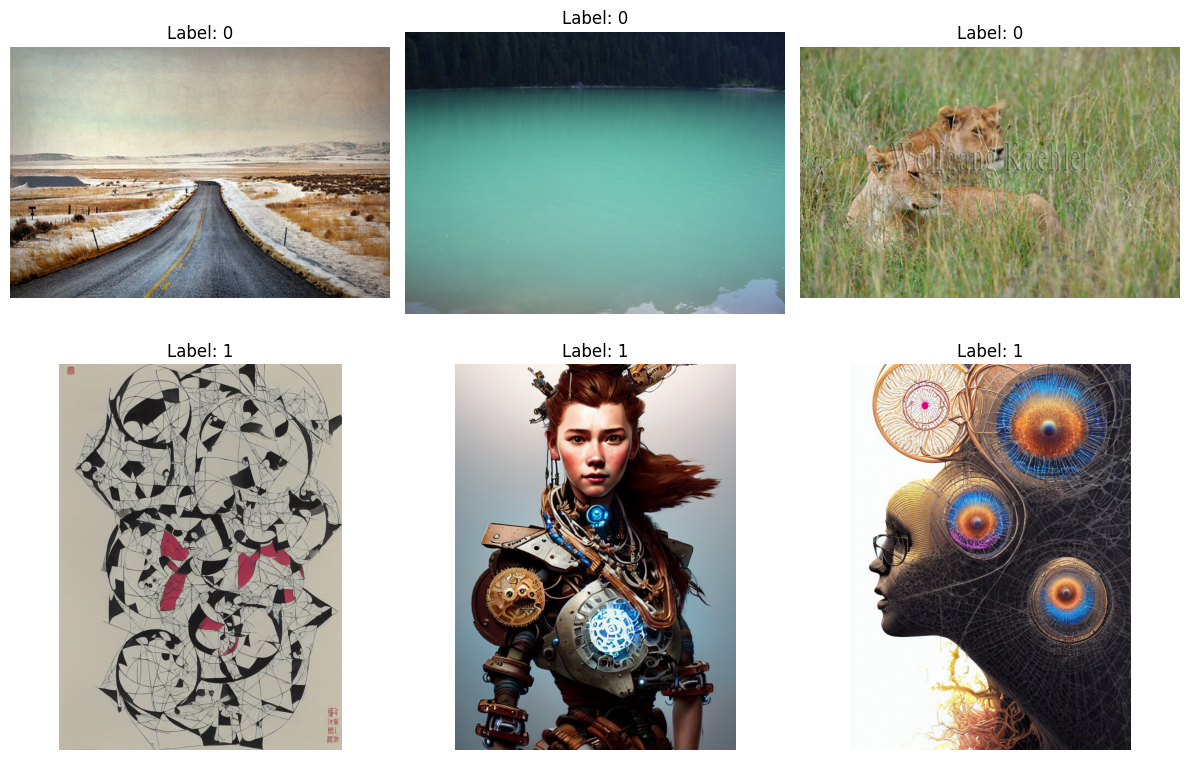

In [ ]:
idx_fake = np.where(np.array(valid_lbls) == 1)[0]
idx_real = np.where(np.array(valid_lbls) == 0)[0]

random_real_idx = np.random.choice(idx_real, 3, replace=False)
random_fake_idx = np.random.choice(idx_fake, 3, replace=False)
plot_idx = np.concatenate([random_real_idx, random_fake_idx])

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
  ax.imshow(valid_imgs[plot_idx[i]])
  ax.set_title(f"Label: {valid_lbls[plot_idx[i]]}")
  ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
ext_images = [{"image": img, "label": lbl} for img, lbl in zip(valid_imgs, valid_lbls)]

for image_dict in ext_images:
  image_np = image_dict["image"]
  if len(image_np.shape) == 2:
    # suitable size for the models-->otherwise we get error
    image_dict["image"] = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)


In [ ]:
target_size =  (256, 256)
resized_ext_data = resize_images(dataset = ext_images, target_size = target_size, name="External Test Images")

assert len(resized_ext_data) == len(ext_images), "The resized train set dimension is different from the original one"

print("Expected Image Shape:", target_size)

for idx, (img, _) in enumerate(resized_ext_data):
  assert img.shape  == (256, 256, 3), f"Error in training set at index {idx}"
print("All images have the same shape")


Resizing External Test Images Images: 100%|██████████| 2000/2000 [00:03<00:00, 566.20it/s] 

Expected Image Shape: (256, 256)
All images have the same shape


In [ ]:
ext_custom_data_np = CustomDataset_NP(resized_ext_data)
batch_size = 1
dataloader_ext_data_np = DataLoader(ext_custom_data_np, batch_size=batch_size, shuffle=False)


In [ ]:
processed_ext_images = [
  (apply_all_filters(rt), apply_all_filters(pt), lbl)
  for rt, pt, lbl in tqdm(
    map(smash_n_reconstruct, resized_ext_data),
    total=len(resized_ext_data),
    desc="Processing External Test Images"
  )
]

ext_custom_data_sr = CustomDataset_SR(
  images = processed_ext_images,
  labels = all_lbls,
)

dataloader_ext_data_sr = DataLoader(ext_custom_data_sr, batch_size=batch_size, shuffle=False)


Processing External Test Images: 100%|██████████| 2000/2000 [10:48<00:00,  3.08it/s]


In [ ]:
torch.save(dataloader_ext_data_sr, 'dataloader_ext_data_sr.pth')
torch.save(dataloader_ext_data_np, 'dataloader_ext_data_np.pth')

# torch.load('dataloader_ext_data_sr.pth')
# torch.load('dataloader_ext_data_np.pth')

### Load the Models

In [ ]:
output_dim = 2
# CNN with S&R
cnn_np = OurNet_NP(output_dim)
cnn_np.load_state_dict(torch.load("ournet_np.pt"))

# CNN
cnn_sr = FullModel(output_dim)
cnn_sr.load_state_dict(torch.load("ournet_sr.pt"))

# ResNet with S&R
resnet_sr_cpy = get_net().to(device)
resnet_sr_cpy.load_state_dict(torch.load("resnet_sr.pt"))

feature_extractor1_cpy = featureExtractionLayer()
feature_extractor2_cpy = featureExtractionLayer()

feature_extractor1_cpy.load_state_dict(torch.load("resnet_sr_f_extr1.pt"))
feature_extractor1_cpy.to(device)

feature_extractor2_cpy.load_state_dict(torch.load("resnet_sr_f_extr2.pt"))
feature_extractor2_cpy.to(device)

# Resnet
resnet_np_cpy = get_net1().to(device)
resnet_np_cpy.load_state_dict(torch.load("resnet_np.pt"))


<All keys matched successfully>

### Make the Predictions and Analyze Results

In [ ]:
# CNN without S&R
cnn_np.eval()

preds_cnn_np = []

with torch.no_grad():
  for (x, y) in dataloader_ext_data_np:

    x = x.to(device)
    y_pred = cnn_np(x)
    y_prob = F.softmax(y_pred, dim=-1)
    top_pred = y_prob.argmax(1, keepdim=True)

    preds_cnn_np.append(top_pred.cpu())

preds_cnn_np = torch.cat(preds_cnn_np, dim=0).numpy()
cm_cnn_np = confusion_matrix(valid_lbls, preds_cnn_np)


In [ ]:
# CNN with S&R
cnn_sr.eval()

preds_cnn_sr = []
with torch.no_grad():
  for rt1, pt1, labels in dataloader_ext_data_sr:
    rt1, pt1, labels = rt1.to(device), pt1.to(device), labels.to(device)
    y_pred = cnn_sr(rt1, pt1)

    y_prob = F.softmax(y_pred, dim=-1)
    top_pred = y_prob.argmax(1, keepdim=True)

    preds_cnn_sr.append(top_pred.cpu())

preds_cnn_sr = torch.cat(preds_cnn_sr, dim=0).numpy()
cm_cnn_sr = confusion_matrix(valid_lbls, preds_cnn_sr)


In [ ]:
# resnet without S&R
resnet_np_cpy.eval()

preds_resnet_np = []

with torch.no_grad():
  for i, (X, _) in enumerate(dataloader_ext_data_np):
    X = X.to(device)
    preds_resnet_np.extend(resnet_np_cpy(X).argmax(dim=1).cpu().numpy())

preds_resnet_np = np.array(preds_resnet_np)
cm_resnet_np = confusion_matrix(valid_lbls, preds_resnet_np)


In [ ]:
# resnet with S&R
resnet_sr_cpy.eval()
feature_extractor1_cpy.eval()
feature_extractor2_cpy.eval()

pred_resnet_sr = []

with torch.no_grad():
  for rt1, pt1, y in dataloader_ext_data_sr:
    rt1, pt1, y = rt1.to(device), pt1.to(device), y.to(device)

    rt1 = feature_extractor1_cpy(rt1)
    pt1 = feature_extractor2_cpy(pt1)

    model_input = torch.sub(rt1, pt1)

    y_pred = resnet_sr_cpy(model_input)

    y_prob = F.softmax(y_pred, dim=-1)
    top_pred = y_prob.argmax(1)
    pred_resnet_sr.append(top_pred)

pred_resnet_sr = torch.cat(pred_resnet_sr).cpu().numpy()
cm_resnet_sr = confusion_matrix(valid_lbls, pred_resnet_sr)


In [ ]:
transformed_ext_images = []
filtered_labels = []

for image_dict, label in zip(ext_images, valid_lbls):
  image_np = image_dict["image"]
  image_pil = Image.fromarray(image_np)
  transformed_ext_images.append({"image": image_pil, "label": label})

preds_susy = np.array([ext_SuSy_pred(transformed_ext_images[idx]["image"], SuSy) for idx in range(len(transformed_ext_images))])
cm_susy = confusion_matrix(valid_lbls, preds_susy)


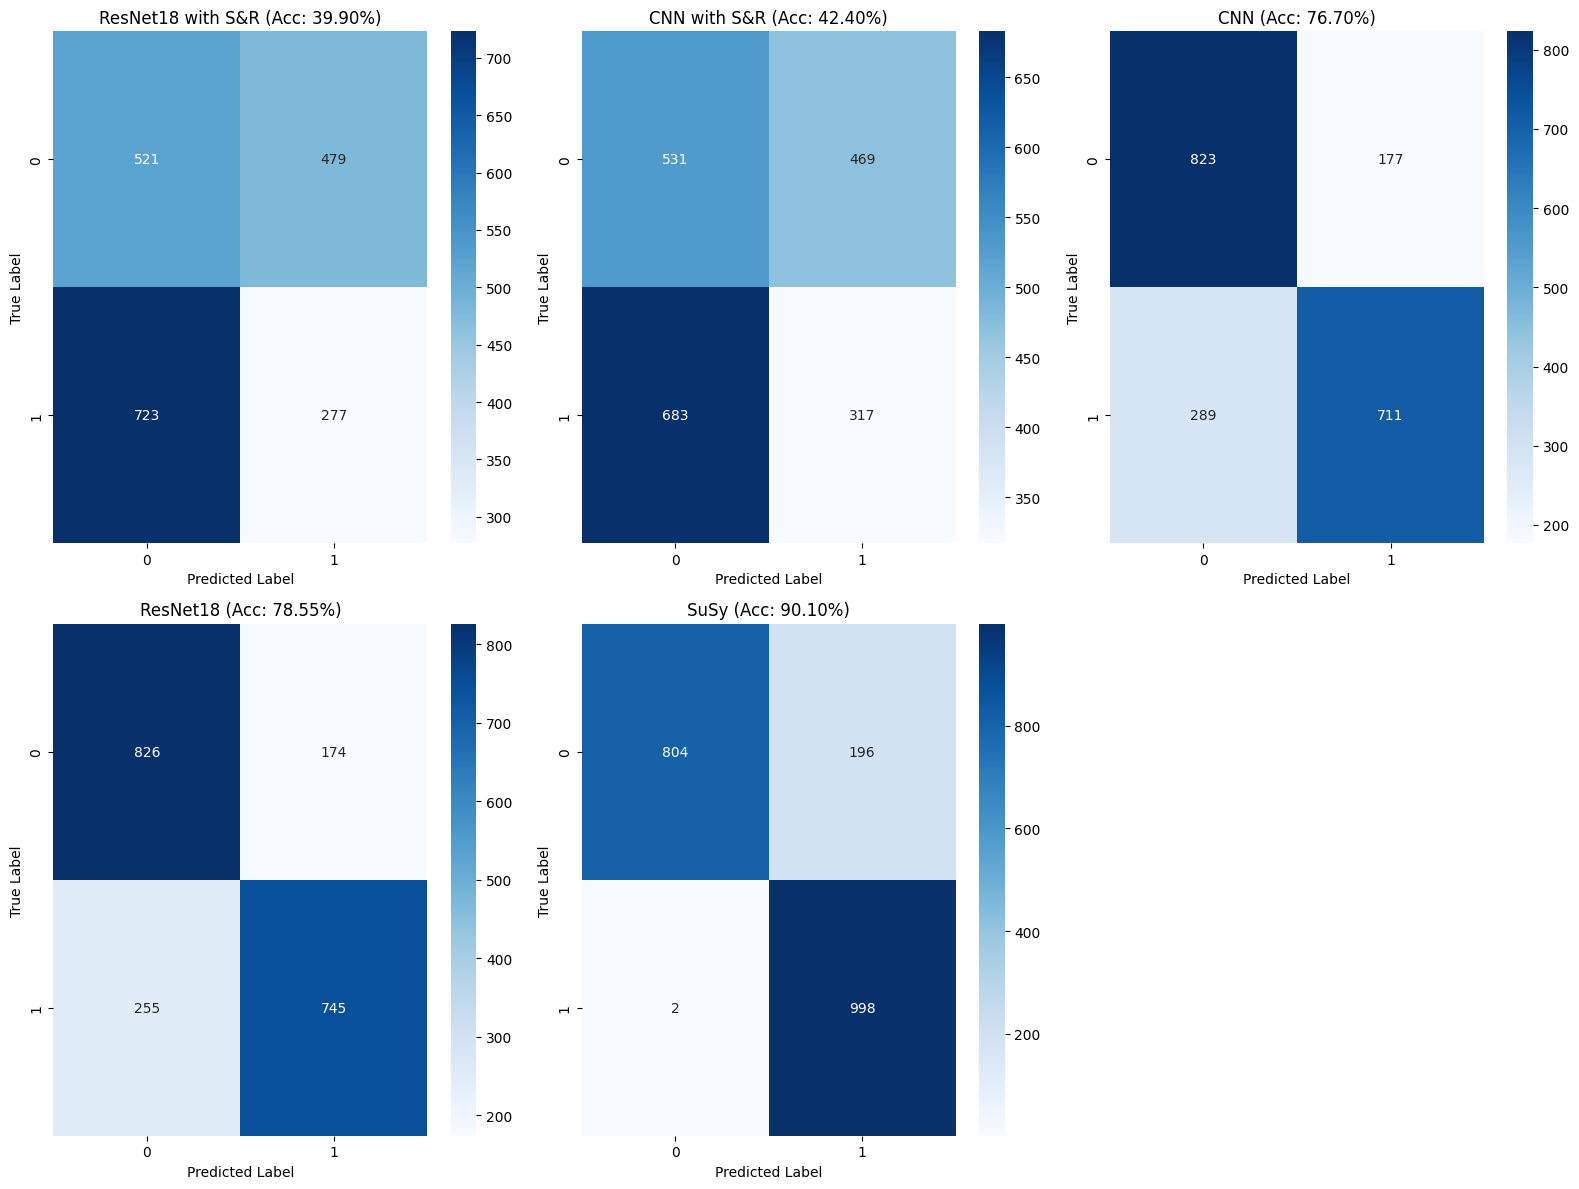

In [ ]:
conf_matrices = [cm_cnn_np, cm_cnn_sr, cm_resnet_sr, cm_susy, cm_resnet_np]
model_names = ["CNN", "CNN with S&R", "ResNet18 with S&R", "SuSy", "ResNet18"]

accuracies = [np.trace(cm) / np.sum(cm) for cm in conf_matrices]
sorted_indices = np.argsort(accuracies)
sorted_conf_matrices = [conf_matrices[i] for i in sorted_indices]
sorted_model_names = [model_names[i] for i in sorted_indices]
sorted_accuracies = sorted(accuracies)

fig, axes = plt.subplots(2, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (cm, model_name, acc) in enumerate(zip(sorted_conf_matrices, sorted_model_names, sorted_accuracies)):
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True, ax=axes[i])
  axes[i].set_title(f"{model_name} (Acc: {acc:.2%})")
  axes[i].set_xlabel("Predicted Label")
  axes[i].set_ylabel("True Label")

for j in range(i + 1, len(axes)):
  fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
